In [39]:
import warnings
warnings.filterwarnings('ignore')

# Tensorflow imports
from tensorflow.test import is_gpu_available
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})
plt.style.use('ggplot')

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [2]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.external

In [3]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop('_id', 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df.head()

,n_tweets,price,sentiment
timestamp,,,
2017-08-02 05:00:00,509.0,2735.27,0.068275
2017-08-02 06:00:00,892.0,2732.12,0.076942
2017-08-02 07:00:00,830.0,2731.96,0.080092
2017-08-02 08:00:00,819.0,2710.21,0.082844
2017-08-02 09:00:00,1196.0,2719.31,0.087544


In [4]:
# Differencing the log values
price_diff = df['price'].diff().dropna()
pd.DataFrame(price_diff.head())

,price
timestamp,
2017-08-02 06:00:00,-3.15
2017-08-02 07:00:00,-0.16
2017-08-02 08:00:00,-21.75
2017-08-02 09:00:00,9.10
2017-08-02 10:00:00,13.68


In [5]:
# Using the Dickey-Fuller test to check for stationarity
results = adfuller(price_diff)
print('P-value: {}'.format(results[1]))

P-value: 2.3494362695911308e-30


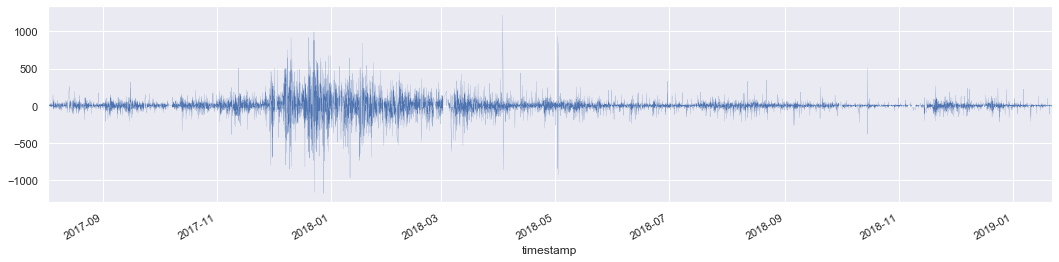

In [9]:
price_diff.plot(linewidth=.15);

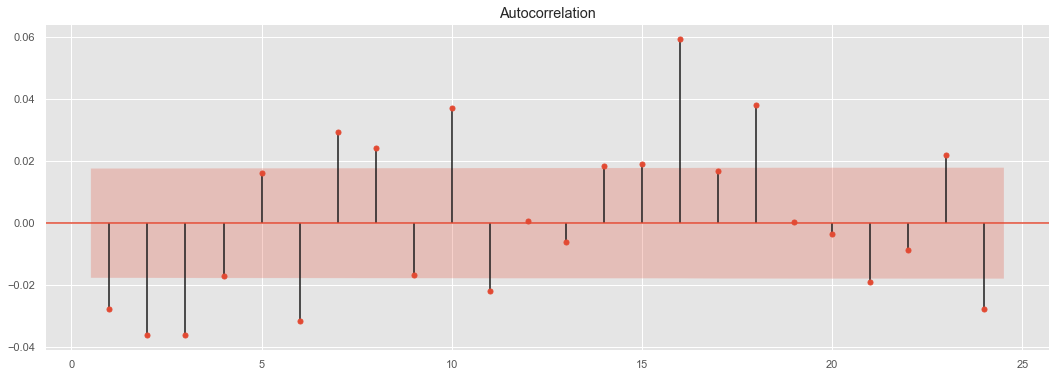

In [69]:
fig = plt.figure(figsize=(18,6))
plot_acf(price_diff, ax=plt.gca(), lags=24, zero=False)
plt.show()

In [ ]:
!pip install fbprophet -q

In [13]:
!pip install plotly

  Stored in directory: C:\Users\Jules\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [14]:
import plotly

In [15]:
from fbprophet import Prophet as proph

In [22]:
df_prophet = df.drop(['n_tweets', 'sentiment'], 1).rename({'price': 'y'}, axis=1)
df_prophet['ds'] = df_prophet.index
df_prophet.head()

,y,ds
timestamp,,
2017-08-02 05:00:00,2735.27,2017-08-02 05:00:00
2017-08-02 06:00:00,2732.12,2017-08-02 06:00:00
2017-08-02 07:00:00,2731.96,2017-08-02 07:00:00
2017-08-02 08:00:00,2710.21,2017-08-02 08:00:00
2017-08-02 09:00:00,2719.31,2017-08-02 09:00:00


In [23]:
# Fitting and training
mod = proph(interval_width=0.95)
mod.fit(df_prophet)

In [58]:
# Setting up predictions to be made
future = mod.make_future_dataframe(periods=720, freq='H')
future.tail()

,ds
13053,2019-02-20 19:00:00
13054,2019-02-20 20:00:00
13055,2019-02-20 21:00:00
13056,2019-02-20 22:00:00
13057,2019-02-20 23:00:00


In [63]:
# Making predictions
forecast = mod.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
13053,2019-02-20 19:00:00,1949.701611,-4957.166775,8794.741213,-4881.449422,8429.730444,11.900127,11.900127,11.900127,2.567877,2.567877,2.567877,9.332250,9.332250,9.332250,0.0,0.0,0.0,1961.601737
13054,2019-02-20 20:00:00,1948.272273,-5238.454304,8943.684308,-4898.627894,8440.954299,15.768874,15.768874,15.768874,7.699168,7.699168,7.699168,8.069706,8.069706,8.069706,0.0,0.0,0.0,1964.041147
13055,2019-02-20 21:00:00,1946.842935,-5028.005117,8844.758432,-4915.806366,8452.178154,21.146961,21.146961,21.146961,14.585947,14.585947,14.585947,6.561014,6.561014,6.561014,0.0,0.0,0.0,1967.989896
13056,2019-02-20 22:00:00,1945.413597,-4852.772885,8551.730952,-4932.984838,8463.402009,23.807387,23.807387,23.807387,19.000587,19.000587,19.000587,4.806799,4.806799,4.806799,0.0,0.0,0.0,1969.220983
13057,2019-02-20 23:00:00,1943.984259,-5096.288042,8866.396815,-4950.163310,8474.625865,20.976902,20.976902,20.976902,18.166037,18.166037,18.166037,2.810865,2.810865,2.810865,0.0,0.0,0.0,1964.961161


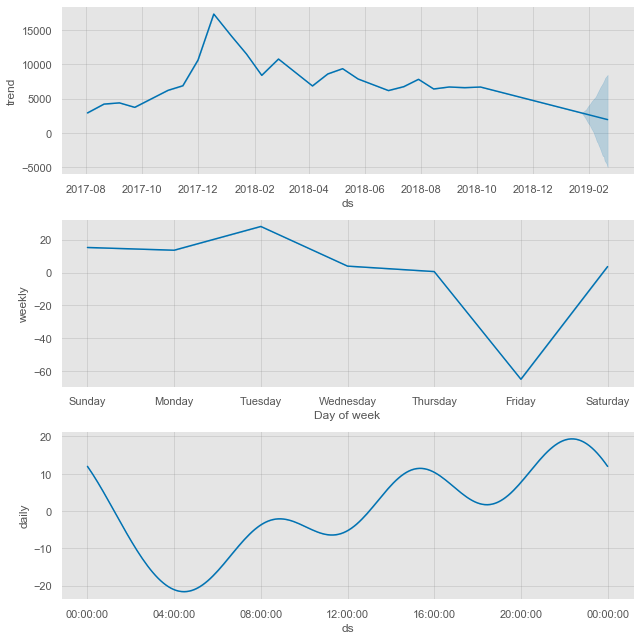

In [64]:
mod.plot_components(forecast)
plt.show()

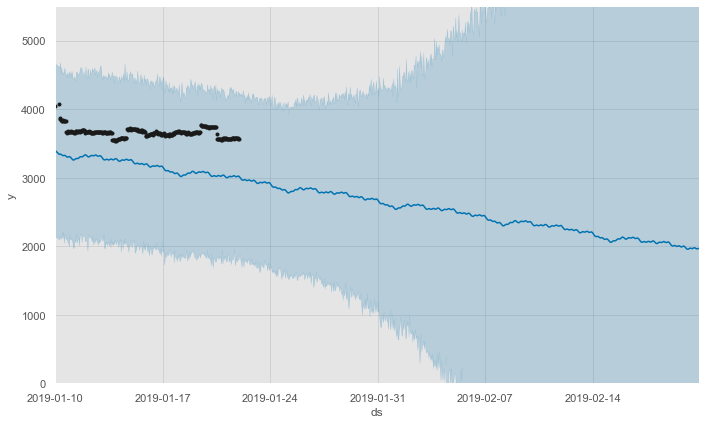

In [68]:
mod.plot(forecast, uncertainty=True)

plt.xlim([datetime.strptime('2019-01-10 00:00:00', '%Y-%m-%d %X'), future.iloc[-1,0]])
plt.ylim([0, 5500])
plt.show()